In [2]:
# Cell 1: Import necessary libraries
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import  ModelCheckpoint
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from keras.applications import EfficientNetV2B3

In [3]:
# Cell 2: Define constants
BATCH_SIZE = 16
IMG_HEIGHT = 300 
IMG_WIDTH = 300
DATA_DIR = "/home/anon/MajorProject/Data/final_asl_mix"

In [5]:
# Cell 3: Load data

#train and test if already separated
# TRAIN_DATA_DIR = "/home/anon/MajorProject/Data/ASL_MAIN/asl_alphabet_train"
# TEST_DATA_DIR = "/home/anon/MajorProject/Data/Synthetic_Dataset/test"

# train_ds = tf.keras.utils.image_dataset_from_directory(
#     TRAIN_DATA_DIR,
#     image_size=(IMG_HEIGHT, IMG_WIDTH),
#     batch_size=BATCH_SIZE)

# val_ds = tf.keras.utils.image_dataset_from_directory(
#     TEST_DATA_DIR,
#     image_size=(IMG_HEIGHT, IMG_WIDTH),
#     batch_size=BATCH_SIZE)


train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

Found 80500 files belonging to 18 classes.
Using 64400 files for training.
Found 80500 files belonging to 18 classes.
Using 16100 files for validation.
['A', 'B', 'Blank', 'C', 'E', 'F', 'G', 'H', 'L', 'N', 'O', 'P', 'Q', 'S', 'V', 'X', 'Y', 'space']


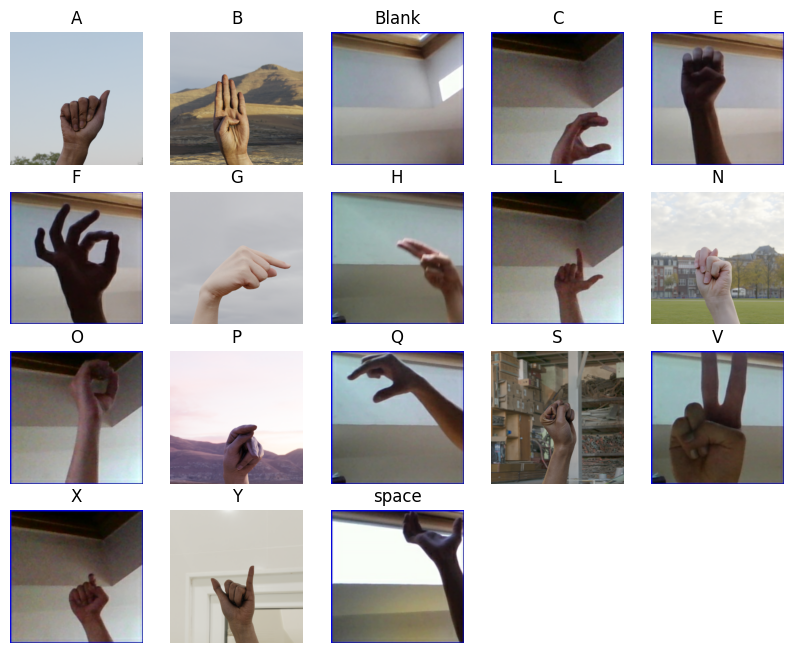

In [6]:
import math

# Calculate the number of rows and columns for the grid
num_rows = math.ceil(math.sqrt(num_classes))
num_cols = num_rows

plt.figure(figsize=(10, 10))

# Create a dictionary to store an image from each class
class_images = {class_name: None for class_name in class_names}

# Iterate over the batches
for images, labels in train_ds:
  # Iterate over the images and labels in the current batch
  for image, label in zip(images, labels):
    # If we haven't stored an image for this class yet, store it
    if class_images[class_names[label]] is None:
      class_images[class_names[label]] = image

  # If we've stored an image for each class, stop iterating over the batches
  if all(image is not None for image in class_images.values()):
    break

# Plot an image for each class
for i, class_name in enumerate(class_names):
  ax = plt.subplot(num_rows, num_cols, i + 1)
  plt.imshow(class_images[class_name].numpy().astype("uint8"))
  plt.title(class_name)
  plt.axis("off")



In [7]:
# Before data augmentation
for images, labels in train_ds.take(1):
  for image in images:
    print(image.shape)


(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)


In [8]:
# Cell 4: Define data augmentation
data_augmentation = keras.Sequential(
    [
        # layers.RandomFlip("horizontal"),
        # layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
        layers.RandomBrightness(0.1),
        # layers.RandomWidth(0.1),
        layers.RandomCrop(IMG_HEIGHT, IMG_HEIGHT),
    ]
)

In [9]:
# Cell 5: Preprocess data #data augmentation and one hot encoding
# train_ds = train_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), tf.one_hot(y, num_classes)))
# val_ds = val_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), tf.one_hot(y, num_classes)))


#no one hot encoding since class > 10:
# data augmentation
train_ds = train_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), y))
val_ds = val_ds.map(lambda x, y: (x, y))

In [8]:
# After data augmentation
for images, labels in train_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), y)).take(1):
    for image in images:
        print(image.shape)

(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)


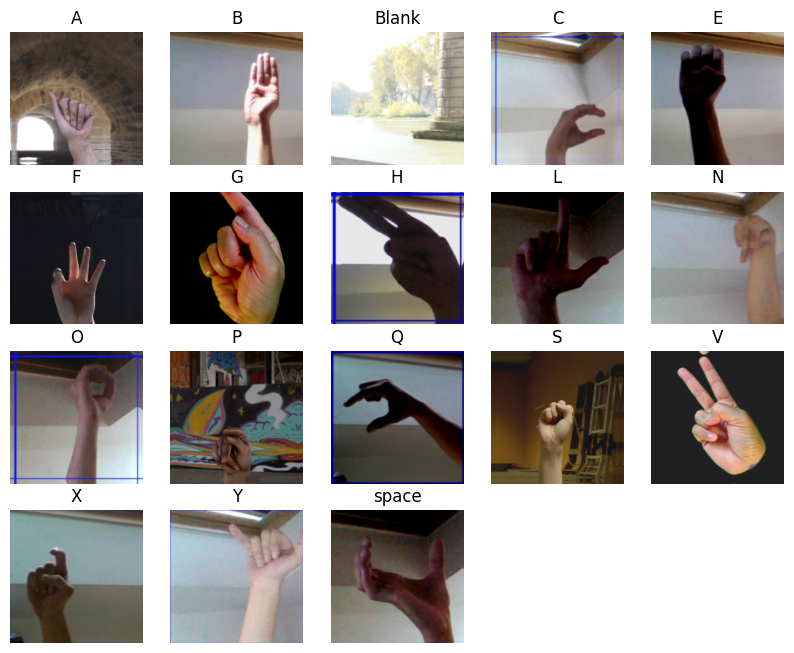

In [10]:
import math

# Calculate the number of rows and columns for the grid
num_rows = math.ceil(math.sqrt(num_classes))
num_cols = num_rows

plt.figure(figsize=(10, 10))

# Create a dictionary to store an image from each class
class_images = {class_name: None for class_name in class_names}

# Iterate over the batches
for images, labels in train_ds:
  # Apply data augmentation
  augmented_images = tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), images)
  
  # Iterate over the images and labels in the current batch
  for image, label in zip(augmented_images, labels):
    # If we haven't stored an image for this class yet, store it
    if class_images[class_names[label]] is None:
      class_images[class_names[label]] = image

  # If we've stored an image for each class, stop iterating over the batches
  if all(image is not None for image in class_images.values()):
    break

# Plot an image for each class
for i, class_name in enumerate(class_names):
  ax = plt.subplot(num_rows, num_cols, i + 1)
  plt.imshow(class_images[class_name].numpy().astype("uint8"))
  plt.title(class_name)
  plt.axis("off")


In [12]:
# Cell 6: Build model
inputs = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
model = EfficientNetV2B3(include_top=False, input_tensor=inputs, weights="imagenet")

# Freeze the pretrained weights
model.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.5
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(num_classes, activation="softmax", name="pred", kernel_regularizer=regularizers.l2(0.01))(x)  # L2 regularization
# outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)  # Removed L2 regularization

# Compile
model = keras.Model(inputs, outputs, name="EfficientNetV2B3")
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-4, decay_steps=10000, decay_rate=0.9)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy","SparseCategoricalAccuracy", "SparseTopKCategoricalAccuracy"])

In [13]:
for images, labels in train_ds.take(1):
    print(f'Training images shape: {images.shape}, labels shape: {labels.shape}')

for images, labels in val_ds.take(1):
    print(f'Validation images shape: {images.shape}, labels shape: {labels.shape}')


Training images shape: (16, 300, 300, 3), labels shape: (16,)
Validation images shape: (16, 300, 300, 3), labels shape: (16,)


In [14]:
print(model.summary())

Model: "EfficientNetV2B3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 300, 300, 3)]        0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 300, 300, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 300, 300, 3)          0         ['rescaling_1[0][0]']         
 tion)                                                                                            
                                                                                                  
 stem_conv (Conv2D)          (None, 150, 150, 40)         1080      ['normalization

In [15]:
# Cell 7: Define callbacks
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint_filepath = '/home/anon/MajorProject/Non_Git/Checkpoints/final/checkpoint-{epoch:02d}-{val_accuracy:.4f}.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True)

In [16]:
#Cell 8 train the model
epochs = 30
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[early_stopping, model_checkpoint,reduce_lr])

Epoch 1/30


2024-02-22 09:57:39.510815: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


   1/4025 [..............................] - ETA: 9:19:57 - loss: 6.2135 - accuracy: 0.0625 - sparse_categorical_accuracy: 0.0625 - sparse_top_k_categorical_accuracy: 0.1250

2024-02-22 09:57:41.210381: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fdc11174890 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-22 09:57:41.210404: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-02-22 09:57:41.219428: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1708575161.268351    5784 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4024/4025 [============================>.] - ETA: 0s - loss: 2.1484 - accuracy: 0.4731 - sparse_categorical_accuracy: 0.4731 - sparse_top_k_categorical_accuracy: 0.7956

/home/anon/miniconda3/envs/major_tf/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4025/4025 [==============================] - 138s 32ms/step - loss: 2.1484 - accuracy: 0.4731 - sparse_categorical_accuracy: 0.4731 - sparse_top_k_categorical_accuracy: 0.7957 - val_loss: 0.8171 - val_accuracy: 0.8498 - val_sparse_categorical_accuracy: 0.8498 - val_sparse_top_k_categorical_accuracy: 0.9778 - lr: 9.5849e-05
Epoch 2/30
4025/4025 [==============================] - 128s 32ms/step - loss: 1.1819 - accuracy: 0.7069 - sparse_categorical_accuracy: 0.7069 - sparse_top_k_categorical_accuracy: 0.9453 - val_loss: 0.5913 - val_accuracy: 0.9104 - val_sparse_categorical_accuracy: 0.9104 - val_sparse_top_k_categorical_accuracy: 0.9907 - lr: 9.1869e-05
Epoch 3/30
4025/4025 [==============================] - 129s 32ms/step - loss: 0.9717 - accuracy: 0.7623 - sparse_categorical_accuracy: 0.7623 - sparse_top_k_categorical_accuracy: 0.9637 - val_loss: 0.5137 - val_accuracy: 0.9265 - val_sparse_categorical_accuracy: 0.9265 - val_sparse_top_k_categorical_accuracy: 0.9937 - lr: 8.8055e-05
Epo

In [17]:
# Cell 10: Save the model
model.save('/home/anon/MajorProject/Non_Git/Models/EfficientnetV2B3/EfficientNetV2B3_FEB_22_18_classes_A_B_Blank_C_E_F_G_H_L_N_O_P_Q_S_V_X_Y_space.h5')

In [18]:
#for categorical_crossentropy
# import numpy as np

# # Initialize lists to store the true and predicted labels
# y_true = []
# y_pred = []

# # Iterate over the validation dataset
# for images, labels in val_ds:
#     # Get the model's predictions
#     pred_probs = model.predict(images)

#     # Convert the predicted probabilities to class labels
#     preds = np.argmax(pred_probs, axis=1)

#     # Convert one-hot encoded labels back to class labels
#     labels = np.argmax(labels.numpy(), axis=1)

#     # Append the labels to the lists
#     y_true.extend(labels)
#     y_pred.extend(preds)

# # Convert the lists to numpy arrays
# y_true = np.array(y_true)
# y_pred = np.array(y_pred)


#for sparse_categorical_crossentropy
import numpy as np

# Initialize lists to store the true and predicted labels
y_true = []
y_pred = []

# Iterate over the validation dataset
for images, labels in val_ds:
    # Get the model's predictions
    pred_probs = model.predict(images)

    # Convert the predicted probabilities to class labels
    preds = np.argmax(pred_probs, axis=1)

    # Append the labels to the lists
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# Convert the lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 [==============================] - 0s 15ms/step


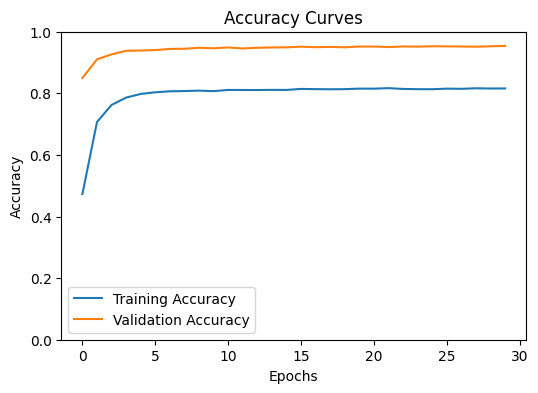

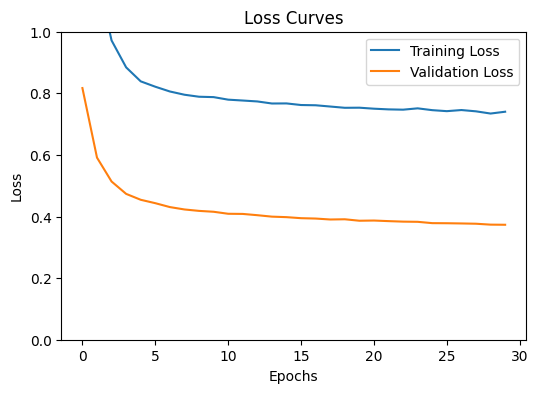

In [19]:
import matplotlib.pyplot as plt

# Plotting the Accuracy Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['accuracy'], linewidth=1.5)
plt.plot(hist.history['val_accuracy'], linewidth=1.5)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()

# Plotting the Loss Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['loss'], linewidth=1.5)
plt.plot(hist.history['val_loss'], linewidth=1.5)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()


Class: A
Precision: 0.9619047619047619
Recall: 0.9439252336448598
F1 Score: 0.9528301886792453
AUC-ROC: 0.9707734776270808

Class: B
Precision: 0.9782135076252724
Recall: 0.9868131868131869
F1 Score: 0.9824945295404814
AUC-ROC: 0.9927482655593255

Class: Blank
Precision: 0.9904306220095693
Recall: 0.9975903614457832
F1 Score: 0.9939975990396158
AUC-ROC: 0.9985332291839264

Class: C
Precision: 0.9712707182320443
Recall: 0.966996699669967
F1 Score: 0.9691289966923925
AUC-ROC: 0.9826425799712484

Class: E
Precision: 0.9524861878453039
Recall: 0.9209401709401709
F1 Score: 0.9364475828354155
AUC-ROC: 0.9590522537634116

Class: F
Precision: 0.9724770642201835
Recall: 0.9443207126948775
F1 Score: 0.9581920903954803
AUC-ROC: 0.9713709865276782

Class: G
Precision: 0.9480968858131488
Recall: 0.9256756756756757
F1 Score: 0.9367521367521368
AUC-ROC: 0.9613587423868781

Class: H
Precision: 0.9327641408751334
Recall: 0.9820224719101124
F1 Score: 0.956759715380405
AUC-ROC: 0.9889402300378964

Class:

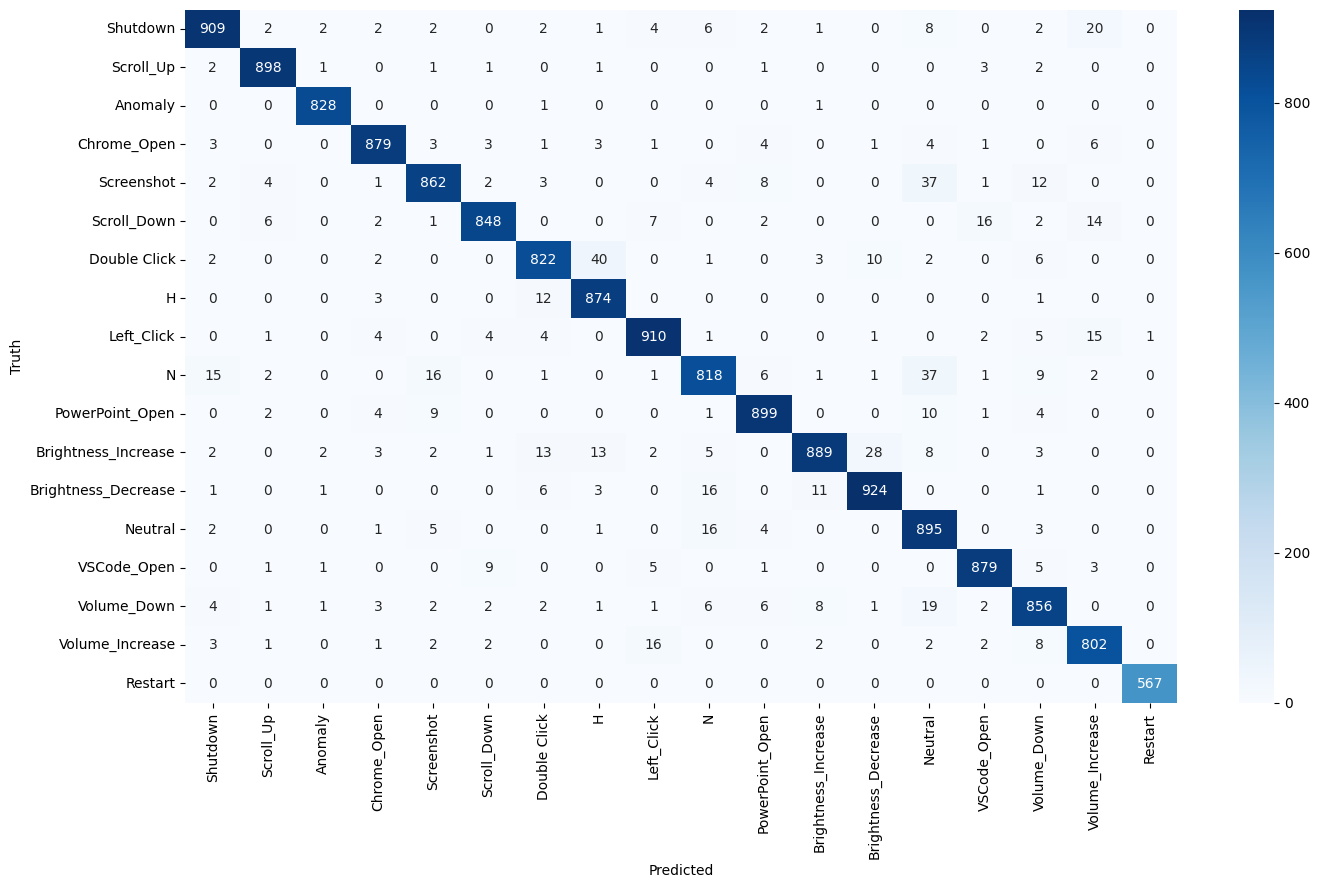

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall, F1 Score for each class
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

# AUC-ROC for each class
lb = LabelBinarizer()
lb.fit(y_true)
y_true_lb = lb.transform(y_true)
y_pred_lb = lb.transform(y_pred)
auc_roc = roc_auc_score(y_true_lb, y_pred_lb, average=None, multi_class='ovr')

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
# Define the mapping between class names and labels
# ['A', 'B', 'Blank', 'C', 'E', 'F', 'G', 'H', 'K', 'L', 'N', 'O', 'P', 'Q', 'S', 'V', 'X', 'Y', 'space']


#feb 22
# 'A', 'B', 'Blank', 'C', 'E', 'F', 'G', 'H', 'L', 'N', 'O', 'P', 'Q', 'S', 'V', 'X', 'Y', 'space'
class_label_mapping = {
    'A': 'Shutdown',
    'B': 'Scroll_Up',
    'Blank': 'Anomaly',
    'C': 'Chrome_Open',
    'E': 'Screenshot',
    'F': 'Scroll_Down',
    'G': 'Double Click',
    'H': 'H',
    # 'I': 'I',
    'L': 'Left_Click',
    'N': 'N',
    'O': 'PowerPoint_Open',
    'P': 'Brightness_Increase',
    'Q': 'Brightness_Decrease',
    # 'R': 'Right_Click',
    'S': 'Neutral',
    'V': 'VSCode_Open',
    # 'W': 'W',
    'X': 'Volume_Down',
    'Y': 'Volume_Increase',
    # '5': 'Neutral',
    'space':'Restart',
    # 'K': 'K'
}
# Create a dictionary that maps indices to labels
class_labels = {i: class_label_mapping[name] for i, name in enumerate(class_names)}

# Print metrics for each class
for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1 Score: {f1[i]}")
    print(f"AUC-ROC: {auc_roc[i]}")
    print()

# # Plot confusion matrix as a heatmap
# plt.figure(figsize=(16,9))
# sns.heatmap(cm, annot=True, fmt='d',xticklabels=class_names, yticklabels=class_names, cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
# plt.show()
plt.figure(figsize=(16,9))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels.values(), yticklabels=class_labels.values(), cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [21]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_2
1 rescaling_1
2 normalization_1
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block1b_project_conv
10 block1b_project_bn
11 block1b_project_activation
12 block1b_drop
13 block1b_add
14 block2a_expand_conv
15 block2a_expand_bn
16 block2a_expand_activation
17 block2a_project_conv
18 block2a_project_bn
19 block2b_expand_conv
20 block2b_expand_bn
21 block2b_expand_activation
22 block2b_project_conv
23 block2b_project_bn
24 block2b_drop
25 block2b_add
26 block2c_expand_conv
27 block2c_expand_bn
28 block2c_expand_activation
29 block2c_project_conv
30 block2c_project_bn
31 block2c_drop
32 block2c_add
33 block3a_expand_conv
34 block3a_expand_bn
35 block3a_expand_activation
36 block3a_project_conv
37 block3a_project_bn
38 block3b_expand_conv
39 block3b_expand_bn
40 block3b_expand_activation
41 block3b_project_conv
42 block3b_project_bn
43 block3b_drop
44 block3b_add
45 block3c_expand_conv
46 block3c_expand_bn
47 bloc

In [22]:
# Cell 9: Unfreeze model and continue training
# for layer in model.layers[-20:]:
#     if not isinstance(layer, layers.BatchNormalization):
#         layer.trainable = True

# # we chose to train the top 2 blocks, i.e. we will freeze
# # the first xxx layers and unfreeze the rest:
# for layer in model.layers[:514]:
#    layer.trainable = False
# for layer in model.layers[514:]:
#    layer.trainable = True
# # we need to recompile the model for these modifications to take effect
# # we train our model again (this time fine-tuning the top 2 blocks
# # alongside the top Dense layers
# optimizer = keras.optimizers.Adam(learning_rate=1e-5)
# model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", metrics=["accuracy","SparseCategoricalAccuracy", "SparseTopKCategoricalAccuracy"])

# epochs = 5
# hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

for layer in model.layers[:410]:
   layer.trainable = False
for layer in model.layers[410:]:
   if not isinstance(layer, layers.BatchNormalization):
      layer.trainable = True

optimizer = keras.optimizers.Adam(learning_rate=1e-6)
model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", metrics=["accuracy","SparseCategoricalAccuracy", "SparseTopKCategoricalAccuracy"])

epochs = 20
# hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds)
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[early_stopping, model_checkpoint,reduce_lr])

Epoch 1/20
4025/4025 [==============================] - 138s 33ms/step - loss: 0.7355 - accuracy: 0.8161 - sparse_categorical_accuracy: 0.8161 - sparse_top_k_categorical_accuracy: 0.9773 - val_loss: 0.3721 - val_accuracy: 0.9535 - val_sparse_categorical_accuracy: 0.9535 - val_sparse_top_k_categorical_accuracy: 0.9968 - lr: 1.0000e-06
Epoch 2/20
4025/4025 [==============================] - 128s 32ms/step - loss: 0.7329 - accuracy: 0.8173 - sparse_categorical_accuracy: 0.8173 - sparse_top_k_categorical_accuracy: 0.9783 - val_loss: 0.3713 - val_accuracy: 0.9535 - val_sparse_categorical_accuracy: 0.9535 - val_sparse_top_k_categorical_accuracy: 0.9968 - lr: 1.0000e-06
Epoch 3/20
4025/4025 [==============================] - 128s 32ms/step - loss: 0.7299 - accuracy: 0.8190 - sparse_categorical_accuracy: 0.8190 - sparse_top_k_categorical_accuracy: 0.9781 - val_loss: 0.3707 - val_accuracy: 0.9535 - val_sparse_categorical_accuracy: 0.9535 - val_sparse_top_k_categorical_accuracy: 0.9968 - lr: 1.0

/home/anon/miniconda3/envs/major_tf/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4025/4025 [==============================] - 129s 32ms/step - loss: 0.7336 - accuracy: 0.8181 - sparse_categorical_accuracy: 0.8181 - sparse_top_k_categorical_accuracy: 0.9778 - val_loss: 0.3707 - val_accuracy: 0.9541 - val_sparse_categorical_accuracy: 0.9541 - val_sparse_top_k_categorical_accuracy: 0.9968 - lr: 1.0000e-06
Epoch 7/20
4025/4025 [==============================] - 129s 32ms/step - loss: 0.7297 - accuracy: 0.8192 - sparse_categorical_accuracy: 0.8192 - sparse_top_k_categorical_accuracy: 0.9783 - val_loss: 0.3705 - val_accuracy: 0.9539 - val_sparse_categorical_accuracy: 0.9539 - val_sparse_top_k_categorical_accuracy: 0.9968 - lr: 1.0000e-06
Epoch 8/20
4025/4025 [==============================] - 130s 32ms/step - loss: 0.7348 - accuracy: 0.8175 - sparse_categorical_accuracy: 0.8175 - sparse_top_k_categorical_accuracy: 0.9786 - val_loss: 0.3701 - val_accuracy: 0.9542 - val_sparse_categorical_accuracy: 0.9542 - val_sparse_top_k_categorical_accuracy: 0.9968 - lr: 1.0000e-06
Epo

In [23]:
# import numpy as np

# # Initialize lists to store the true and predicted labels
# y_true = []
# y_pred = []

# # Iterate over the validation dataset
# for images, labels in val_ds:
#     # Get the model's predictions
#     pred_probs = model.predict(images)

#     # Convert the predicted probabilities to class labels
#     preds = np.argmax(pred_probs, axis=1)

#     # Convert one-hot encoded labels back to class labels
#     labels = np.argmax(labels.numpy(), axis=1)

#     # Append the labels to the lists
#     y_true.extend(labels)
#     y_pred.extend(preds)

# # Convert the lists to numpy arrays
# y_true = np.array(y_true)
# y_pred = np.array(y_pred)

#for sparse_categorical_crossentropy
import numpy as np

# Initialize lists to store the true and predicted labels
y_true = []
y_pred = []

# Iterate over the validation dataset
for images, labels in val_ds:
    # Get the model's predictions
    pred_probs = model.predict(images)

    # Convert the predicted probabilities to class labels
    preds = np.argmax(pred_probs, axis=1)

    # Append the labels to the lists
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# Convert the lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 [==============================] - 0s 16ms/step


Class: A
Precision: 0.9657387580299786
Recall: 0.936656282450675
F1 Score: 0.9509752240379546
AUC-ROC: 0.9672711286072494

Class: B
Precision: 0.975
Recall: 0.9857142857142858
F1 Score: 0.980327868852459
AUC-ROC: 0.9921000658327848

Class: Blank
Precision: 0.9904306220095693
Recall: 0.9975903614457832
F1 Score: 0.9939975990396158
AUC-ROC: 0.9985332291839264

Class: C
Precision: 0.9659714599341384
Recall: 0.9680968096809681
F1 Score: 0.967032967032967
AUC-ROC: 0.9830280638491075

Class: E
Precision: 0.9486899563318777
Recall: 0.9284188034188035
F1 Score: 0.9384449244060475
AUC-ROC: 0.9626596786811769

Class: F
Precision: 0.9736540664375716
Recall: 0.9465478841870824
F1 Score: 0.9599096555618295
AUC-ROC: 0.9725174626829374

Class: G
Precision: 0.9468208092485549
Recall: 0.9222972972972973
F1 Score: 0.9343981745579008
AUC-ROC: 0.9596366844098898

Class: H
Precision: 0.9346895074946466
Recall: 0.9808988764044944
F1 Score: 0.9572368421052632
AUC-ROC: 0.9884441785046798

Class: L
Precision: 

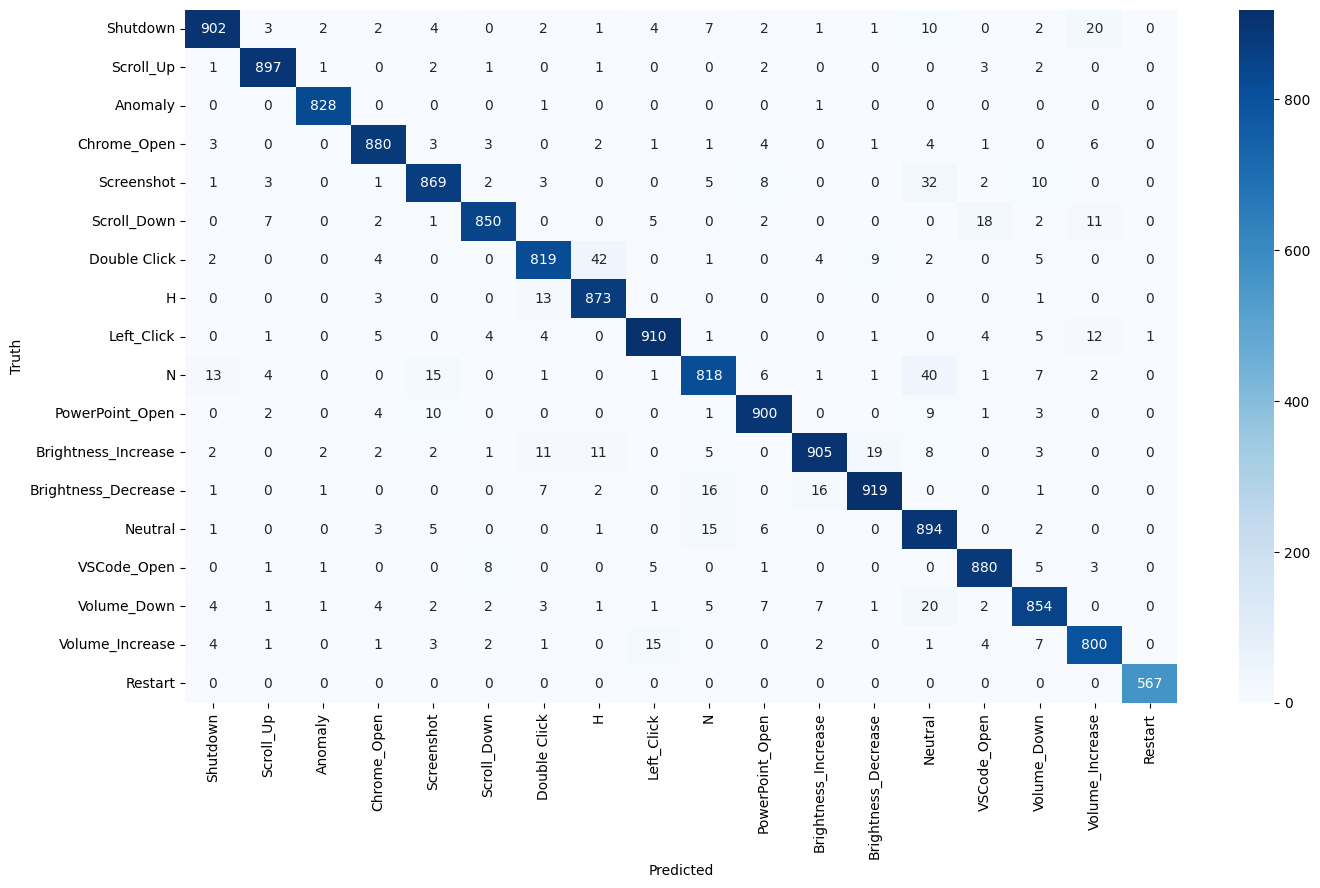

In [24]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# from sklearn.metrics import confusion_matrix, roc_auc_score
# from sklearn.preprocessing import LabelBinarizer
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np

# # Accuracy
# accuracy = accuracy_score(y_true, y_pred)

# # Precision, Recall, F1 Score
# average = 'macro'  # or 'micro', 'weighted', depending on the problem
# precision = precision_score(y_true, y_pred, average=average)
# recall = recall_score(y_true, y_pred, average=average)
# f1 = f1_score(y_true, y_pred, average=average)

# # AUC-ROC for multiclass
# lb = LabelBinarizer()
# lb.fit(y_true)
# y_true_lb = lb.transform(y_true)
# y_pred_lb = lb.transform(y_pred)
# auc_roc = roc_auc_score(y_true_lb, y_pred_lb, average=average, multi_class='ovr')

# # Confusion Matrix
# cm = confusion_matrix(y_true, y_pred)

# # Print metrics
# print(f"Accuracy: {accuracy}")
# print(f"Precision: {precision}")
# print(f"Recall: {recall}")
# print(f"F1 Score: {f1}")
# print(f"AUC-ROC: {auc_roc}")

# #for dataset_alpha
# # class_names = ['Brightness_Decrease', 'Brightness_Increase', 'Chrome_Open', 'Cursor_Movement', 'Double_Click', 'Left_Click', 'Nothing', 'PowerPoint_Open', 'Right_Click', 'Screenshot', 'Scroll', 'Shutdown', 'VSCode_Open', 'Volume_Decrease', 'Volume_Increase']


# # class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

# # class_names = ['A', 'B', 'Blank', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
# # class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
# # class_names = ['A', 'B', 'Blank', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'L', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
# #for final_asl_mix
# # class_names = ['A', 'B', 'Blank', 'C', 'E', 'F', 'G', 'H', 'I', 'L', 'N', 'O', 'P', 'Q', 'R', 'S', 'U', 'V', 'W', 'X', 'Y']

# #feb 20 final
# class_names = ['5', 'A', 'B', 'Blank', 'C', 'E', 'F', 'G', 'H', 'I', 'L', 'N', 'O', 'P', 'Q', 'R', 'S', 'V', 'W', 'X', 'Y', 'space']


# # Plot confusion matrix as a heatmap
# plt.figure(figsize=(16,9))
# sns.heatmap(cm, annot=True, fmt='d',xticklabels=class_names, yticklabels=class_names, cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
# plt.show()
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall, F1 Score for each class
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

# AUC-ROC for each class
lb = LabelBinarizer()
lb.fit(y_true)
y_true_lb = lb.transform(y_true)
y_pred_lb = lb.transform(y_pred)
auc_roc = roc_auc_score(y_true_lb, y_pred_lb, average=None, multi_class='ovr')

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
#feb 22
# 'A', 'B', 'Blank', 'C', 'E', 'F', 'G', 'H', 'L', 'N', 'O', 'P', 'Q', 'S', 'V', 'X', 'Y', 'space'
class_label_mapping = {
    'A': 'Shutdown',
    'B': 'Scroll_Up',
    'Blank': 'Anomaly',
    'C': 'Chrome_Open',
    'E': 'Screenshot',
    'F': 'Scroll_Down',
    'G': 'Double Click',
    'H': 'H',
    # 'I': 'I',
    'L': 'Left_Click',
    'N': 'N',
    'O': 'PowerPoint_Open',
    'P': 'Brightness_Increase',
    'Q': 'Brightness_Decrease',
    # 'R': 'Right_Click',
    'S': 'Neutral',
    'V': 'VSCode_Open',
    # 'W': 'W',
    'X': 'Volume_Down',
    'Y': 'Volume_Increase',
    # '5': 'Neutral',
    'space':'Restart',
    # 'K': 'K'
}
# Create a dictionary that maps indices to labels
class_labels = {i: class_label_mapping[name] for i, name in enumerate(class_names)}

# Print metrics for each class
for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1 Score: {f1[i]}")
    print(f"AUC-ROC: {auc_roc[i]}")
    print()

# # Plot confusion matrix as a heatmap
# plt.figure(figsize=(16,9))
# sns.heatmap(cm, annot=True, fmt='d',xticklabels=class_names, yticklabels=class_names, cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
# plt.show()
plt.figure(figsize=(16,9))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels.values(), yticklabels=class_labels.values(), cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [25]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

# Convert the true and predicted labels to a binary matrix
lb = LabelBinarizer()
lb.fit(y_true)
y_true_bin = lb.transform(y_true)
y_pred_bin = lb.transform(y_pred)

# Calculate the macro-averaged AUC-ROC
auc_roc_macro = roc_auc_score(y_true_bin, y_pred_bin, average='macro', multi_class='ovr')
print(f"Macro-Averaged AUC-ROC: {auc_roc_macro}")


Macro-Averaged AUC-ROC: 0.9764763685877629


In [27]:
model.save('/home/anon/MajorProject/Non_Git/Models/EfficientNetV2B3_FEB_22_18_classes_A_B_Blank_C_E_F_G_H_L_N_O_P_Q_S_V_X_Y_space_finetuned.h5')

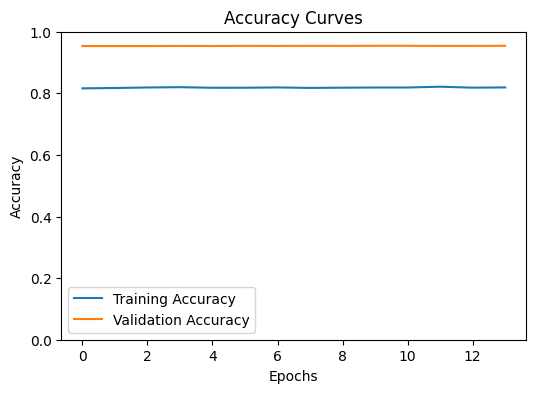

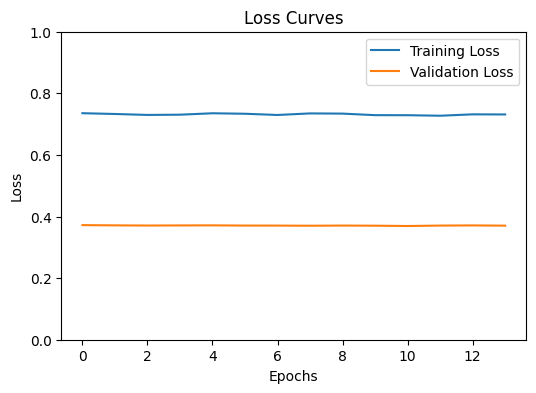

In [28]:
import matplotlib.pyplot as plt

# Plotting the Accuracy Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['accuracy'], linewidth=1.5)
plt.plot(hist.history['val_accuracy'], linewidth=1.5)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()

# Plotting the Loss Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['loss'], linewidth=1.5)
plt.plot(hist.history['val_loss'], linewidth=1.5)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()
